In [83]:
# System identification python code

####################### PACKAGES #######################
import numpy as np
import numpy.linalg
import numpy.matlib

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import OrthogonalMatchingPursuit

from scipy.integrate import odeint
from scipy.special import comb

import pandas as pd

import matplotlib.pyplot as plt

## CVXPY package
import cvxpy as cp

In [84]:
####################### FUNCTIONS #######################
# Define local functions
def loss_fn(X, Y, beta):
    return cp.norm2(X @ beta - Y)**2

def regularizer(beta):
    return cp.norm1(beta)

def objective_fn(X, Y, beta, lambd):
    return loss_fn(X, Y, beta) + lambd * regularizer(beta)

def mse(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn(X, Y, beta).value

# Simulate dynamical system

def duffing(x, t, gamma=0.1, kappa=1, epsilon=5):
    # Compute dynamics
    dsdt = [x[1], -gamma * x[1] - kappa * x[0] - epsilon * x[0] ** 3]
    return dsdt

gamma=0.1
kappa=1
epsilon=5

def integrate_dynamics(x, t, poly_d, beta):
    
    n_states = X.shape[1]
    
    if beta.shape[0] != comb(n_states + poly_d, poly_d):
        raise Exception("Order of polynomial and dimension of beta do not match.")
        
    # Compute dynamics
    poly = PolynomialFeatures(poly_d)
    Phi = poly.fit_transform(x.reshape(1, -1))
    dxdt = np.dot(Phi,beta).flatten()

    return dxdt

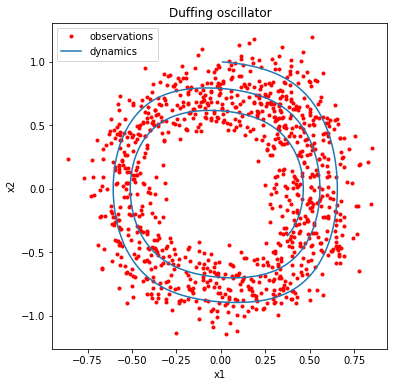

In [85]:
####################### GENERATE DATA #######################

# Simulate dynamics

t0, tf = 0, 10  # start and end
dt = 0.01  # time step
n_times = int(np.floor(tf-t0)/dt + 1) #Number of time instances
n_states = 2 #Number of state variables
t_span = np.linspace(t0, tf, n_times)
x0 = [0, 1]
X = odeint(duffing, x0, t_span)
x1 = X[:,0]
x2 = X[:,1]

#Corrupt states by adding noise --> Observation model y(t) = x(t) + e(t)
sigma = 0.1
E = sigma * np.random.randn(n_times,n_states)#Additive zero-mean white noise (Assumed Gaussian)

Y = X + E #(remove initial condition)
X = X#(remove initial condition)
t = t_span
m_samples = len(t)#Number of samples

y1 = Y[:,0]
y2 = Y[:,1]

#Plot dynamical system and observations
plt.figure(figsize = (6,6))
plt.plot(y1,y2,'r.')
plt.plot(x1[1:],x2[1:])
plt.title('Duffing oscillator')
plt.ylabel('x2')
plt.xlabel('x1')
plt.legend(['observations','dynamics'])
plt.show()

In [86]:
# INITIAL GUESS WITH SMALL PERTURBATION

#Generate multi-variate Vandermonde matrix of degree poly_d in n variables
poly_d = 3
p_basis = int(comb(n_states + poly_d, poly_d))

beta_true = np.zeros((p_basis, n_states))
beta_true[2,0] = 1

beta_true[2,1] = -gamma
beta_true[1,1] = -kappa
beta_true[6,1] = -epsilon

pert = 0.01
beta = beta_true + pert * np.random.rand(p_basis,n_states)

# Simulate dynamics
t0, tf = 0, 10  # start and end
dt = 0.01  # time step
n_times = int(np.floor(tf-t0)/dt + 1) #Number of time instances
t_span = np.linspace(t0, tf, n_times)
x0 = [0, 1]
X_int = odeint(integrate_dynamics, x0, t_span, args=(poly_d, beta))
x1_int = X_int[:,0]
x2_int = X_int[:,1]
t_int = t_span

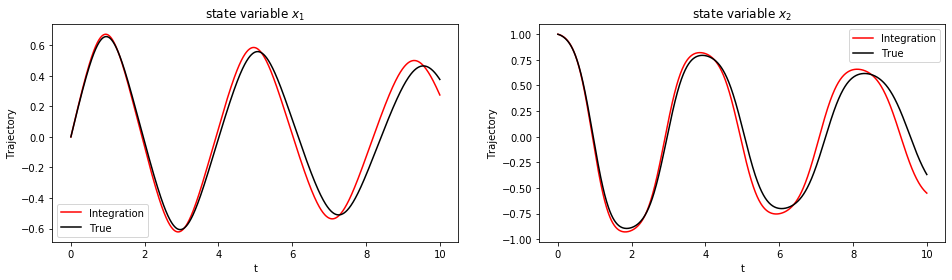

In [87]:
fig, axs = plt.subplots(1, n_states, figsize=(16,4))

for state in range(n_states):

    axs[state].plot(t_int, X_int[:,state],'r')
    axs[state].plot(t_int, X[:,state],'k')
    axs[state].set_title(r'state variable $x_{0}$'.format(state+1))
    axs[state].set_xlabel('t')
    axs[state].set_ylabel('Trajectory')
    axs[state].legend(['Integration', 'True'])
    


In [94]:
# INITIAL GUESS WITH LARGER PERTURBATION

#Generate multi-variate Vandermonde matrix of degree poly_d in n variables
poly_d = 3
p_basis = int(comb(n_states + poly_d, poly_d))

beta_true = np.zeros((p_basis, n_states))
beta_true[2,0] = 1

beta_true[2,1] = -gamma
beta_true[1,1] = -kappa
beta_true[6,1] = -epsilon

pert = 0.1
beta = beta_true + pert * np.random.rand(p_basis,n_states)

# Simulate dynamics
t0, tf = 0, 10  # start and end
dt = 0.01  # time step
n_times = int(np.floor(tf-t0)/dt + 1) #Number of time instances
t_span = np.linspace(t0, tf, n_times)
x0 = [0, 1]
X_int = odeint(integrate_dynamics, x0, t_span, args=(poly_d, beta))
x1_int = X_int[:,0]
x2_int = X_int[:,1]
t_int = t_span

/home/alexandre/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


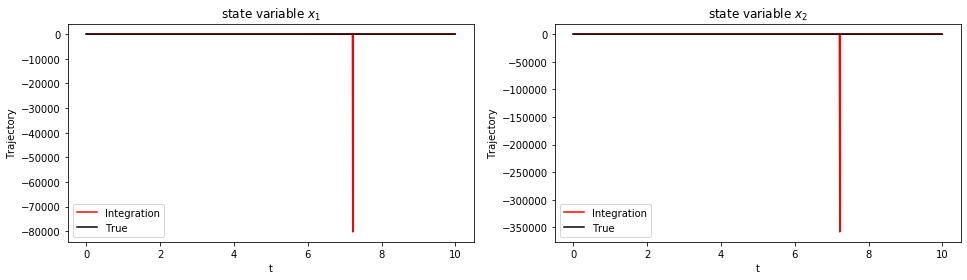

In [95]:
fig, axs = plt.subplots(1, n_states, figsize=(16,4))

for state in range(n_states):

    axs[state].plot(t_int, X_int[:,state],'r')
    axs[state].plot(t_int, X[:,state],'k')
    axs[state].set_title(r'state variable $x_{0}$'.format(state+1))
    axs[state].set_xlabel('t')
    axs[state].set_ylabel('Trajectory')
    axs[state].legend(['Integration', 'True'])